In [1]:
#import Pkg; Pkg.add("ApproxFun")
using LinearAlgebra, SpecialFunctions, Plots, ApproxFun, SparseArrays, Distributions, StatsBase, BenchmarkTools
gr(size=(600,400))
default(fmt = :png)

The lanczos algorithm below can be found in the package ApproxFun. It constructs a set of $n$ orthogonal polynomials $\pi_{i}(x)$ with respect to a weighting function $w(x)$.

$\int \pi_{i}(x) \pi_{j}(x) w(x) dx = \delta_{ij}$

https://approximatelyfunctioning.blogspot.com/2020/09/quasi-matrices-orthogonal-polynomials.html

In [2]:
function lanczos(w,N)
    x = Fun(identity,space(w))
    f1=Fun(1/sqrt(sum(w)),space(x))
    P = Array{Fun}(undef, N + 1)
    β = Array{eltype(w)}(undef, N)
    γ = Array{eltype(w)}(undef, N)
    P[1] = f1
    v = x*P[1]
    β[1] = sum(w*v*P[1])
    v = v - β[1]*P[1]
    γ[1] = sqrt(sum(w*v^2))
    P[2] = v/γ[1]
    for k = 2:N
        v = x*P[k] - γ[k-1]*P[k-1]
        β[k] = sum(w*v*P[k])
        v = v - β[k]*P[k]
        γ[k] = sqrt(sum(w*v^2))
        P[k+1] = v/γ[k]
    end
    P,β,γ
end

lanczos (generic function with 1 method)

In [3]:
w=Fun(GaussWeight(),[1.])
n=3
Y, β,γ=lanczos(w,n)
println("did lanczos")

did lanczos


In [4]:
#check matrix Y'Y
Y_transpose_Y = zeros(n+1,n+1)
for i = 1:n+1
    for j = 1:n+1
        Y_transpose_Y[i,j] = sum(Y[i]*w*Y[j])
        #lets drop all the values that are small
        if(Y_transpose_Y[i,j] < 1e-15)
            Y_transpose_Y[i,j] = 0
        end
    end
end
sparse(Y_transpose_Y)

4×4 SparseMatrixCSC{Float64, Int64} with 4 stored entries:
 1.0   ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅   1.0

The next function takes in a finite set of orthogonal polynomials $\pi_{i}(x)$ and samples from the continuous DPP which they define. In particular, $\frac{1}{n}\sum_{i=1}^{n} \pi_{i}^{2}$ defines a probability density function which we can sample from. 

After we sample from the density function, we modify all the orthogonal polynomials so they all run through zero at the sampling point $x_{0}$. This means we will not sample from the same spot twice. We construct a discrete vector from the function evaluations $v_{i} = \pi_{i}(x_{0})$. Then we use the qr factorization to construct $n-1$ other vectors which are orthogonal to the first vector. We define the next set of orthogonal polynomials as;

$\pi_{k} = Q_{kj}\pi_{j}$

Because we know that all the rows and columns of $Q$, besides the first one are orthogonal to the first one and the first one is exactly the old $\pi_{i}(x_{0})$, we know that the new functions will have only one $\pi_{k}$ which is nonzero at $x_{0}$. We delete that function before sampling again

Additionally, since these functions are smooth, the next density function should smoothly approach zero at that point and should remain zero for all future samplings. Unfortunately, ApproxFun struggles to represent non-smooth functions and for under some circumstances it complains that it is working with very high order polynomials. 

In [5]:
function contProjDPP(Y_in,w,debug)
    Y = copy(Y_in)
    G = fill(0.0,size(Y_in,1))
    for iter =1:size(Y_in,1)
        sY = size(Y,1)
        p = mean(Y.^2)
        if(debug)
            print("Inner Product of My PDF is: ")
            println(sum(p*w))
            P_disp = plot(p * w, title = "PDF we sample from", size=(400,400))
            #png(fn) 
            display(P_disp)
        end
        f = Fun(p * w,Domain(-100..100))
        r=ApproxFun.sample(f,1)[1]
        G[iter] = r
        vector = zeros(1,sY)
        for i = 1:sY
            vector[i] = Y[i](G[iter])
        end
        Q = qr(vector').Q
        Y_new = Array{Fun}(undef, sY - 1)
        for k = 2:sY
            Y_new[k-1] = Y[k] * 0.0
        end
        for j = 1:sY
            for k = 2:sY
                Y_new[k - 1] = Y_new[k - 1] + Q[j,k] * Y[j]
            end
        end
        Y = Y_new
    end
    return sort(G)
end


contProjDPP (generic function with 1 method)

We construct a histogram by sampling from the DPP of the GUE. The histogram matches the first probability density function fairly closely.

did lanczos
Finished Sampling


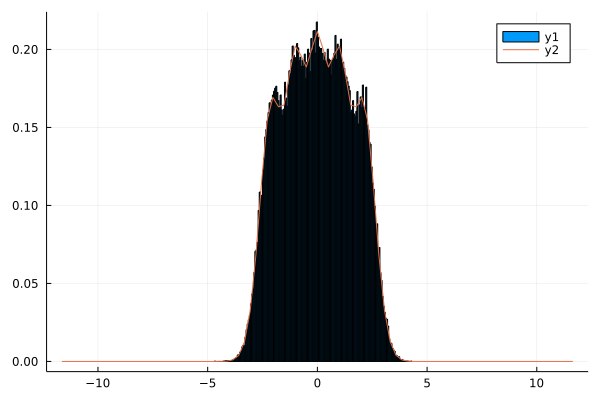

In [6]:
w=Fun(GaussWeight(),[1.])
n=4
Y, β,γ=lanczos(w,n)
println("did lanczos")

#num_iter = 20000 #for n=3, this takes 2 minutes
num_iter = 20000
data = zeros(num_iter,n+1)
for iter = 1:num_iter
    d1 = contProjDPP(Y,w,false)
    #println(d1)
    #println(size(d1))
    data[iter,:] = d1
end
println("Finished Sampling")
data = reshape(data,((n+1)*num_iter,1))
histogram(data[:,:], normed=true, nbins=floor(Int, sqrt((n+1.0)*num_iter)))
#I overlay the function Approxfun Lanczos gave me to sample the first time
#The good agreement confirms that the contProjDPP is implemented correctly
plot!(mean(Y.^2)*w)

did lanczos
Inner Product of My PDF is: 1.0000000000000002

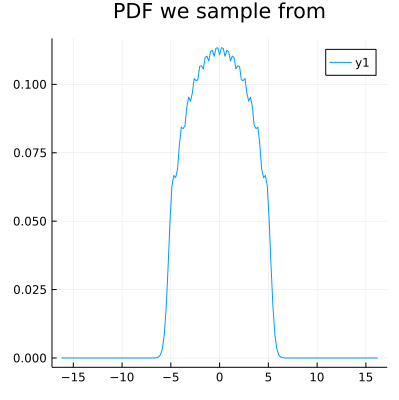


Inner Product of My PDF is: 

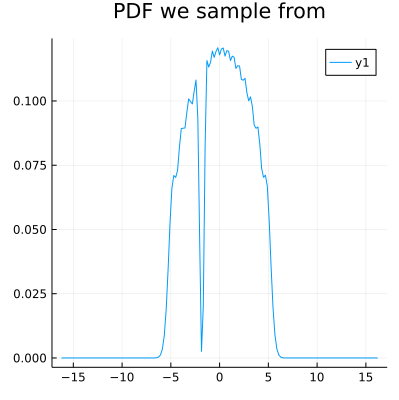

1.0


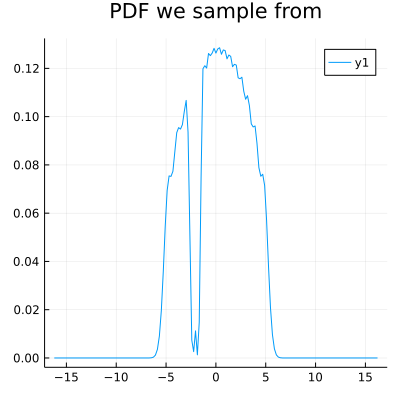

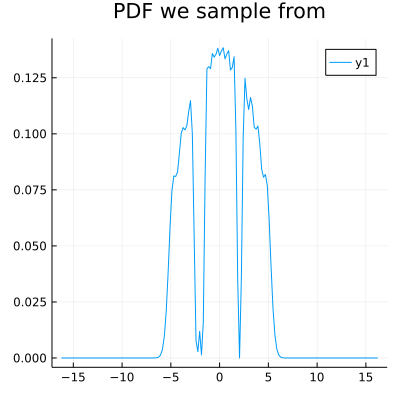

Inner Product of My PDF is: 1.0
Inner Product of My PDF is: 0.9999999999999997


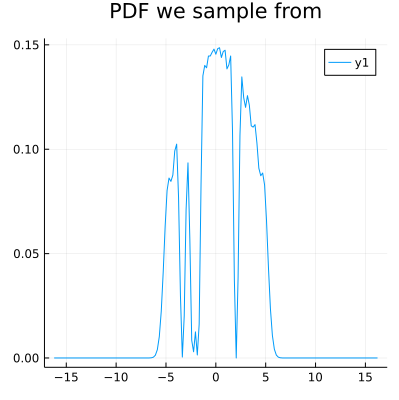

Inner Product of My PDF is: 1.0000000000000002
Inner Product of My PDF is: 

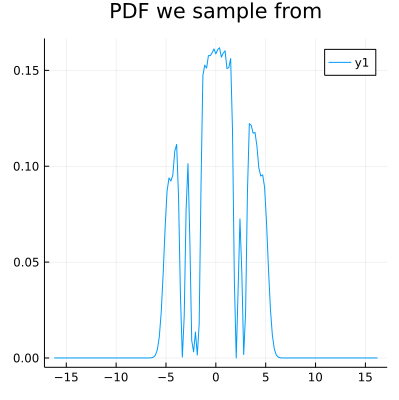

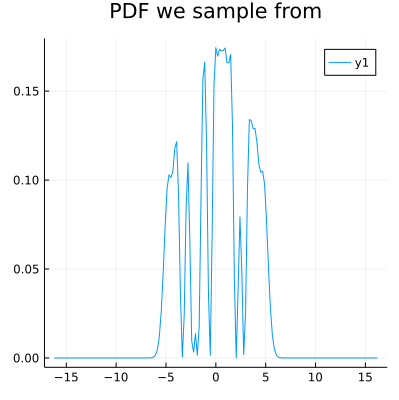

1.0000000000000002
Inner Product of My PDF is: 1.0
Inner Product of My PDF is: 

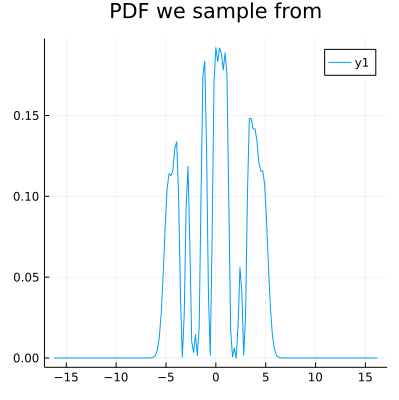

1.0


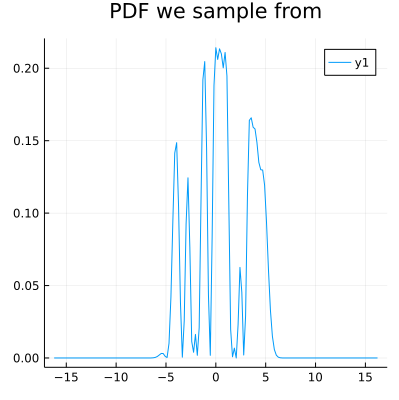

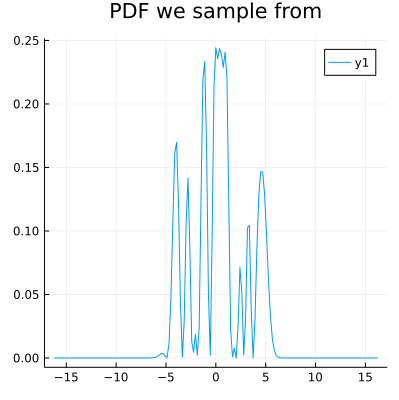

Inner Product of My PDF is: 1.0
Inner Product of My PDF is: 1.0000000000000002


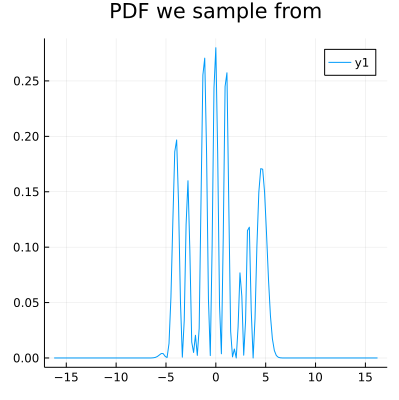

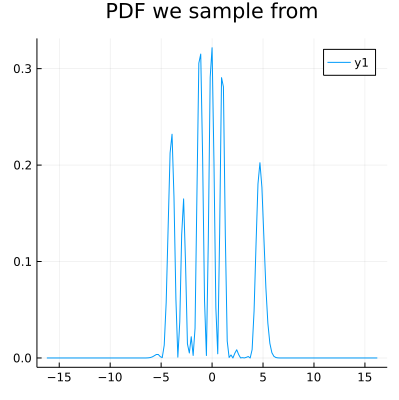

Inner Product of My PDF is: 1.0000000000000002
Inner Product of My PDF is: 1.0


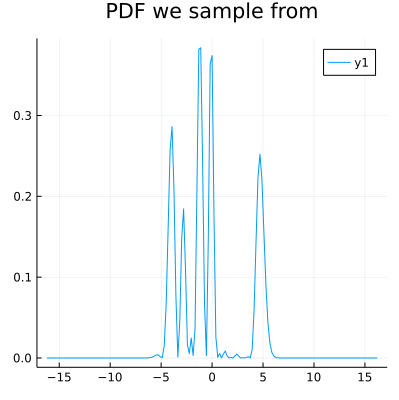

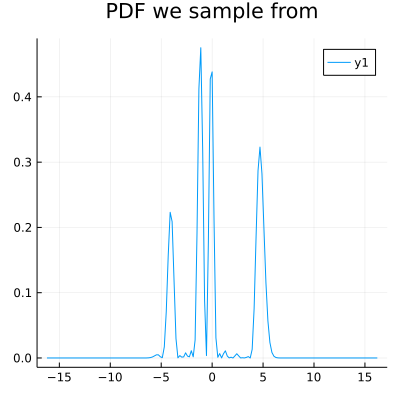

Inner Product of My PDF is: 1.0
Inner Product of My PDF is: 1.0000000000000002


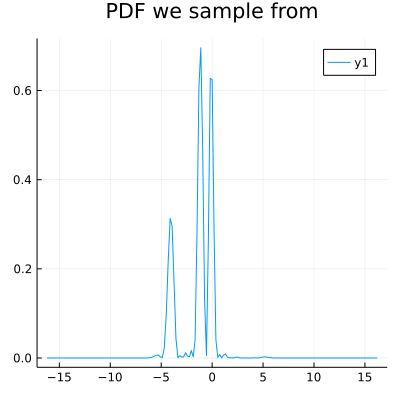

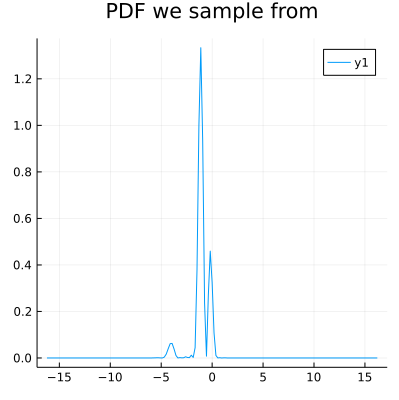

Inner Product of My PDF is: 1.0000000000000004
Inner Product of My PDF is: 1.0000000000000004
sampled DPP


In [7]:
#This is how I make the movie demonstration of how DPP sampling actually works in function space
w=Fun(GaussWeight(),[1.])   # exp(-x^2)
n=15
Y, β,γ=lanczos(w,n)
println("did lanczos")
contProjDPP(Y,w,true)
println("sampled DPP")

1.0000000000000002


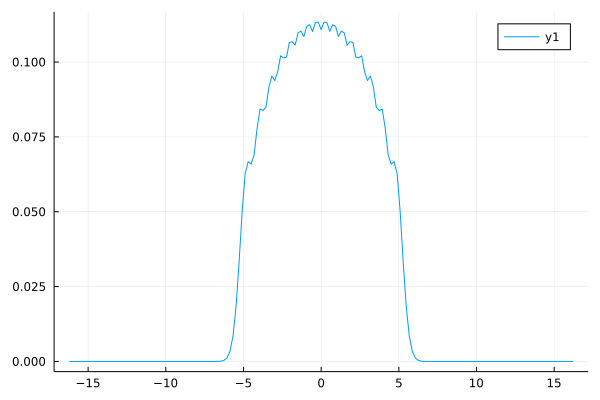

In [8]:
phi = copy(Y)
for j = 1:n+1
    phi[j] = Y[j] / sqrt(sqrt(pi))
end
println(sum(mean(Y.^2)*w))
plot(mean(Y.^2)*w)

In [9]:
function contProjDPPJacobi(Y_in,w,debug)
    Y = copy(Y_in)
    G = fill(0.0,size(Y_in,1))
    for iter =1:size(Y_in,1)
        sY = size(Y,1)
        p = mean(Y.^2)
        if(debug)
            print("Inner Product of My PDF is: ")
            println(sum(p*w))
            P_disp = plot(p * w, title = "PDF we sample from", size=(400,400))
            #png(fn) 
            display(P_disp)
        end
        f = Fun(p * w,Domain(-1..1))
        r=ApproxFun.sample(f,1)[1]
        G[iter] = r
        vector = zeros(1,sY)
        for i = 1:sY
            vector[i] = Y[i](G[iter])
        end
        Q = qr(vector').Q
        Y_new = Array{Fun}(undef, sY - 1)
        for k = 2:sY
            Y_new[k-1] = Y[k] * 0.0
        end
        for j = 1:sY
            for k = 2:sY
                Y_new[k - 1] = Y_new[k - 1] + Q[j,k] * Y[j]
            end
        end
        Y = Y_new
    end
    return sort(G)
end

contProjDPPJacobi (generic function with 1 method)

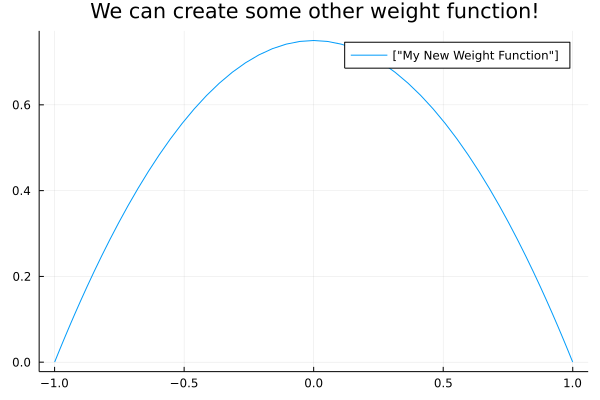

did lanczos


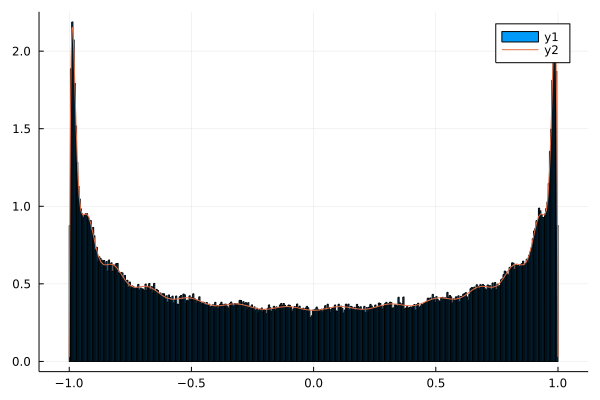

Finished Sampling


In [10]:
x=Fun(identity,-1..1)
alpha = 1
beta  = 1
wNew = (1 - x)^alpha * (1 + x)^beta
wNew = wNew / sum(wNew)
n = 13
NewWeight = plot(wNew,label = ["My New Weight Function"], title="We can create some other weight function!")
display(NewWeight)
Y, β,γ=lanczos(wNew,n)
println("did lanczos")
num_iter = 20000
data = zeros(num_iter,n+1)
for iter = 1:num_iter
    d1 = contProjDPPJacobi(Y,wNew,false)
    #println(d1)
    #println(size(d1))
    data[iter,:] = d1
end
println("Finished Sampling")
data = reshape(data,((n+1)*num_iter,1))
myHistogram = histogram(data[:,1], normed=true, nbins=floor(Int, sqrt((n+1.0)*num_iter)))
plot!(mean(Y.^2)*wNew)
display(myHistogram)
#Below I show the jacobi ensemble

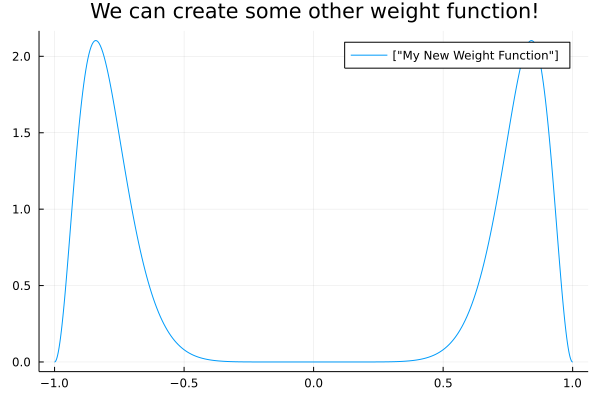

did lanczos


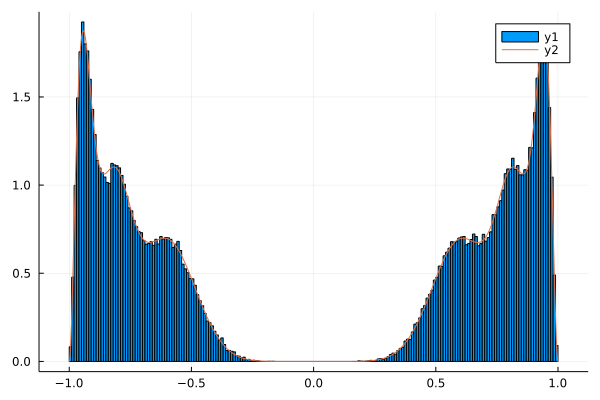

Finished Sampling


In [11]:
x=Fun(identity,-1..1)
wNew = sin(x^4 * pi)
wNew = wNew * wNew
wNew = wNew / sum(wNew)
n = 5
NewWeight = plot(wNew,label = ["My New Weight Function"], title="We can create some other weight function!")
display(NewWeight)
Y, β,γ=lanczos(wNew,n)
println("did lanczos")
num_iter = 20000
data = zeros(num_iter,n+1)
for iter = 1:num_iter
    d1 = contProjDPPJacobi(Y,wNew,false)
    #println(d1)
    #println(size(d1))
    data[iter,:] = d1
end
println("Finished Sampling")
data = reshape(data,((n+1)*num_iter,1))
myHistogram = histogram(data[:,1], normed=true, nbins=floor(Int, sqrt((n+1.0)*num_iter)))
plot!(mean(Y.^2)*wNew)
display(myHistogram)
#Here we demonstrate the capability to do arbitrary DPP so long as they are smooth!

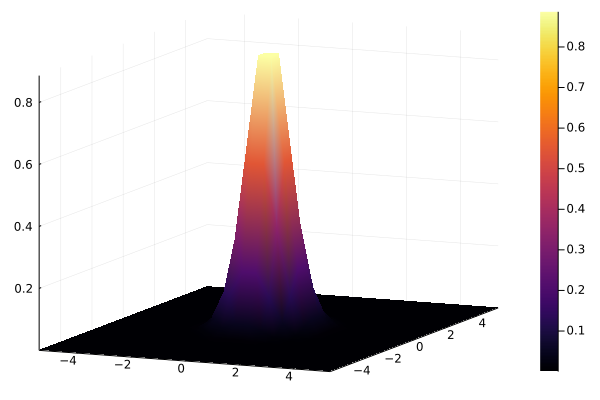

In [12]:
w2=Fun(GaussWeight()^2,[1.]) 
plot(w2)

$\sum_{j_{1}<j_{2}}^{n+1} \begin{vmatrix}
\pi_{j_{1}}(x) & \pi_{j_{2}}(x)\\
\pi_{j_{1}}(y) & \pi_{j_{2}}(y)
\end{vmatrix}^{2}$ 

did lanczos
did DPP
Normalized: 0.999999999999999


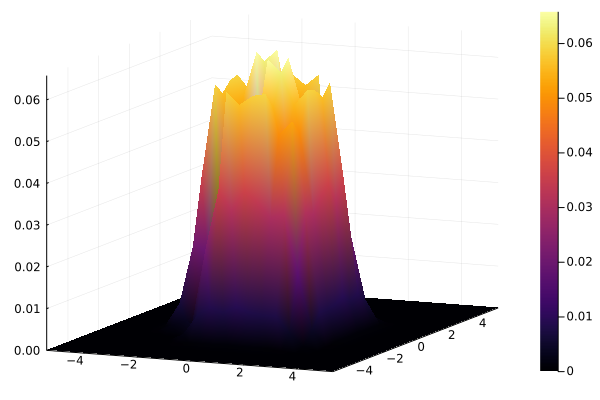

In [13]:
#some correlation functions
w2=Fun(GaussWeight()^2,[1.])
n=3
Y, β,γ=lanczos(w,n)
println("did lanczos")
contProjDPP(Y,w,false)
summation=Fun(GaussWeight()^2,[0.])
println("did DPP")
for j2 = 1:n+1
    for j1 = 1:j2-1
        det = Y[j1]⊗Y[j2] - Y[j2]⊗Y[j1]
        #print("Added a term of integral: ")
        #println(sum(det * det * w2))
        if (j1==1 && j2==2)
            summation = det * det
        else
            summation = summation + det * det
        end
    end
end
summation = summation  / (n*(n+1))
s = sum(summation * w2)
print("Normalized: ")
println(s)
surface(summation * w2)